## Simulate the runout of a landslide on a synthetic landscape

### import necessary packages and components

In [1]:
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import numpy as np
import matplotlib.animation as animation

from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FlowDirectorMFD
from landlab import imshowhs_grid
from landlab.components.mass_wasting_router.mass_wasting_runout import (MassWastingRunout,
                                                                        shear_stress_grains,
                                                                        shear_stress_static,
                                                                        erosion_rate,
                                                                        erosion_coef_k)
from landlab.io import read_esri_ascii

### define landslide (regolith) and MassWastingRunout parameters Sc, qsi and k

In [2]:
ls_width = 3 # number of cells wide, must be odd number
ls_length = 5 # number of cells long
ls_h = 3 # thickness
soil_thickness = 2 # thickness of soil covering flume
qs_max = ls_h

### define key MWR parameters

In [3]:
qsc = 0.075#.25 # threshold flux
Sc = 0.03#0.03 # critical slope
k = 0.3#0.005 # erosion coefficient
Dp = 0.2 # particle diameter
vs = 0.4
ros = 2650
rof = 1000
dx = 10
eta = 0.2

In [4]:
Tau_g = shear_stress_grains(vs,ros,Dp,qs_max,0.5,9.81)
Tau_s = shear_stress_static(vs,ros,rof,qs_max,0.5,9.81)

In [5]:
Sc*dx

0.3

In [6]:
elimit = qsc*10
elimit

0.75

In [7]:
k = erosion_coef_k(elimit/dx,Tau_g,eta,dx)
k


0.19208878057393053

### select the sythetic terrain. Modeled runout on terrains shown below were modeled with the following parameters:
#### ls_width = 3, ls_length = 5, ls_h = 3, soil_thickness = 2
#### qs_max = ls_h, qsc = .25, Sc = 0.03, k = 0.005, Dp = 0.2 

In [8]:
terrain_id = 'B'
clim = [-ls_h/2,ls_h/2] # colorbar limits for plot, plots below use [-0.5, 0.5]


<div>
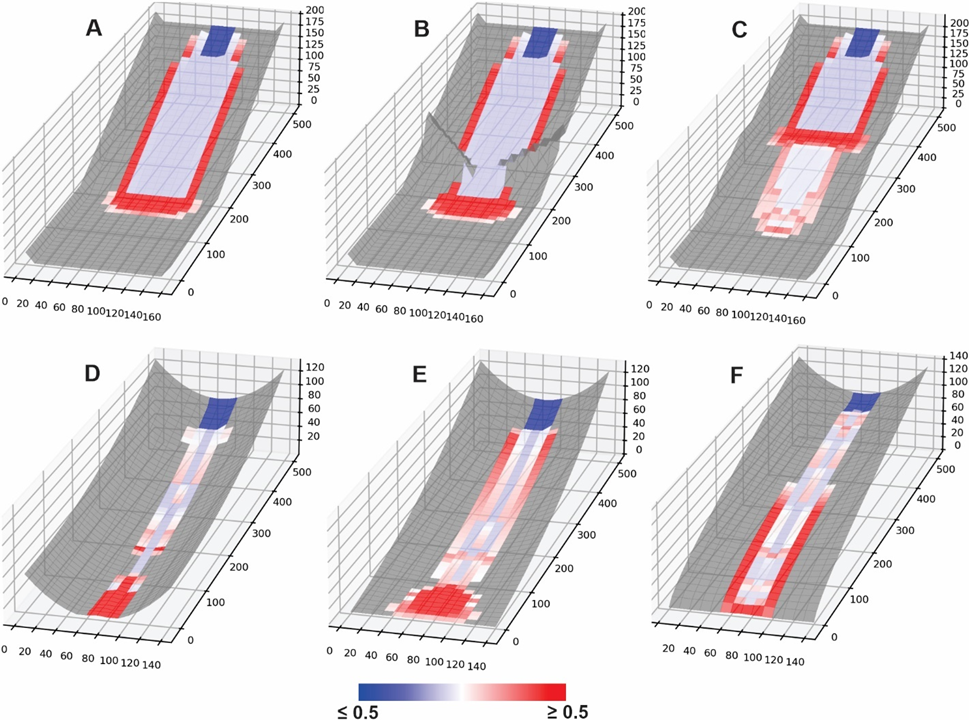
</div>

#### functions needed for plotting and defining model domain

In [9]:
# ploting functions, adapted from flow-director notebooks
def surf_plot(mg,
              surface='topographic__elevation',
              title='',
              zlim = None):
    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    print('Zmin{}, Zmax{}'.format(Z.min(), Z.max()))
    color = cm.gray_r((Z - Z.min())*2 / (Z.max() - Z.min()))
    surf = ax.plot_surface(mg.x_of_node.reshape(mg.shape),
                           mg.y_of_node.reshape(mg.shape),
                           Z,
                           rstride=1,
                           cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False,
                           alpha = 0.67,
                           shade = True)
    ax.view_init(elev=20, azim=-75)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    ax.view_init(elev=20, azim=-75)
    plt.title(title)
    ax.set_box_aspect([.30, 1, 0.2])
#     if zlim:
#         ax.set_zlim(zlim)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 7)
    return surf

def surf_plot_drape(mg,
                  surface='topographic__elevation',
                  shading = 'dem_dif_o',
                  title='',
                  clim = [-1,1],
                  cmtype = 'diverging', 
                  zlim = None,
                  colorbar =False):
    
    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    S = mg.at_node[shading].reshape(mg.shape) 
    # normalize colormap values (0 to 1) so that centered at mid point 
    # between clim[0] (min) and clim[1] (max) values
    S_ = S.copy()
    S_[S>clim[1]] = clim[1]; S_[S<clim[0]] = clim[0]
    ci = (S_ - clim[0]) / (clim[1] - clim[0])
    if cmtype == 'diverging':
        color = cm.bwr(ci)#cm.seismic(ci)
    elif cmtype == 'sequential':
        color = cm.terrain(ci)
    color[ci == 0.5]=[ 0.50196078,  0.50196078,  0.50196078,  1 ] # set zero values to grey
    surf = ax.plot_surface(mg.x_of_node.reshape(mg.shape),
                           mg.y_of_node.reshape(mg.shape),
                           Z,
                           rstride=1,
                           cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False,
                           alpha = 0.65,
                           shade = False)
    ax.view_init(elev=20, azim=-75)
    plt.title(title)
    ax.set_box_aspect([.30, 1, 0.2])
    ax.tick_params(axis = 'both', which = 'major', labelsize = 7)
    if colorbar:
        if cmtype == 'diverging':
            m = cm.ScalarMappable(cmap=cm.bwr, norm=surf.norm)
        if cmtype == 'sequential':
            m = cm.ScalarMappable(cmap=cm.terrain, norm=surf.norm)
        m.set_array(np.array(clim))
        plt.colorbar(m, ax=ax,shrink=0.25)
    return surf


# functions to define the landslide and select runout profile nodes
def ls_profile_nodes(c, ls_width):
    if ls_width == 1:
        cc = int(c/2)+1
        pf = mg.nodes[:,cc]
    elif (ls_width <= c) and (ls_width%2 == 1):
        cc = []
        for i in range(ls_width):
            dif = -((ls_width)%2)+i
            cc.append(int(c/2)+dif+1)
        cc = np.array(cc)
        pf = mg.nodes[:,int(c/2)+1]
    return pf, cc

def landslide_nodes(ls_length, cc):
    # landslide nodes
    lsn = mg.nodes[-(ls_length+1):-1,cc]   
    return lsn

#### load the selected synthetic terrain

In [10]:
#%%flume
# names = ['PlanarSlope.asc','PlanarSlopeWithConstriction.asc', 'ConvergentConcavev2.asc', 'Convex.asc', 'VariableConvergenceConcavev6.asc', 'VaryConvergenceConvexv6.asc', 'WideFlumeWithBenchv2.asc']
names = {'A':'A_PlanarSlope.asc','B':'B_PlanarSlopeWithConstriction.asc','C':'C_WideFlumeWithBenchv.asc','D':'D_ConvergentConcave.asc','E':'E_VariableConvergenceConcave.asc','F':'F_VaryConvergenceConvex.asc'}
# flume = names[flume_number]
flume = names[terrain_id]

flume_dir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/Flumes/'

mg, z = read_esri_ascii(flume_dir+flume, name='topographic__elevation')

#### define the raster model grid representation of the sythetic terrain

In [11]:
#%% set up model
# set boundary conditions
mg.set_closed_boundaries_at_grid_edges(True, True, True, False) #close all boundaries
dem = mg.at_node['topographic__elevation']
# mg.set_watershed_boundary_condition_outlet_id(cc,dem)

# domain for plots
xmin = mg.node_x.min(); xmax = mg.node_x.max(); ymin = mg.node_y.min(); ymax = mg.node_y.max()
  
mg.at_node['node_id'] = np.hstack(mg.nodes)


# add flow direction field
# d8 flow directions
fa = FlowAccumulator(mg, 
                      'topographic__elevation',
                      flow_director='FlowDirectorD8')
fa.run_one_step()

    # soil thickness
thickness = np.ones(mg.number_of_nodes)*soil_thickness
mg.add_field('node', 'soil__thickness',thickness)

# set particle diameter
mg.at_node['particle__diameter'] = np.ones(len(mg.node_x))*Dp


#### define the landslide on the raster model grid

In [12]:
c = mg.number_of_node_columns-2
pf, cc = ls_profile_nodes(c, ls_width)
lsn = landslide_nodes(ls_length, cc)

# define landslide location
mg.at_node['mass__wasting_id'] = np.zeros(mg.number_of_nodes).astype(int)
mg.at_node['mass__wasting_id'][lsn] = 1

# define landslide thickness
mg.at_node['soil__thickness'][lsn] = ls_h  

In [13]:
mg.at_node['all_nans'] = np.ones(mg.number_of_nodes)*np.nan

#### take a look at the flume, and location of the landslide on the flume

Zmin0.0, Zmax200.19


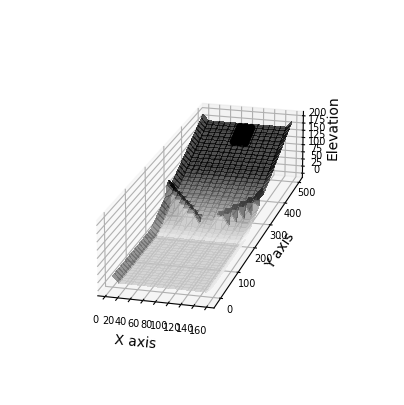

In [14]:
%matplotlib inline
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection='3d')
surf = surf_plot(mg)
ax.scatter(mg.node_x[lsn], mg.node_y[lsn], mg.at_node['topographic__elevation'][lsn], 
       marker = '.', color = 'k',alpha = 1, s = 100)
plt.show()

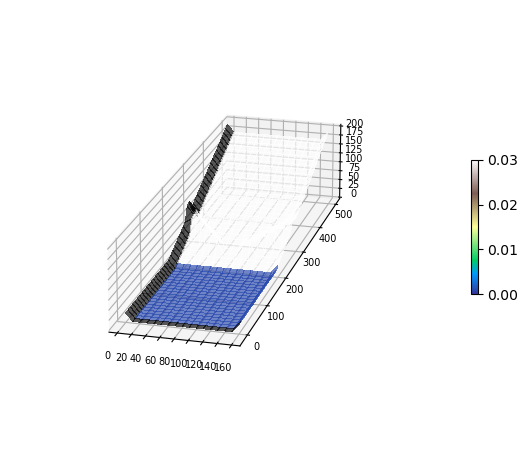

In [15]:
mg.at_node['topographic__steepest_slope'][mg.boundary_nodes] = np.nan
%matplotlib inline
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(projection='3d')
surf_plot_drape(mg,
              surface='topographic__elevation',
              shading = 'topographic__steepest_slope',
              title='',
              clim = [0,0.03],
              cmtype = 'sequential',
              colorbar = True)

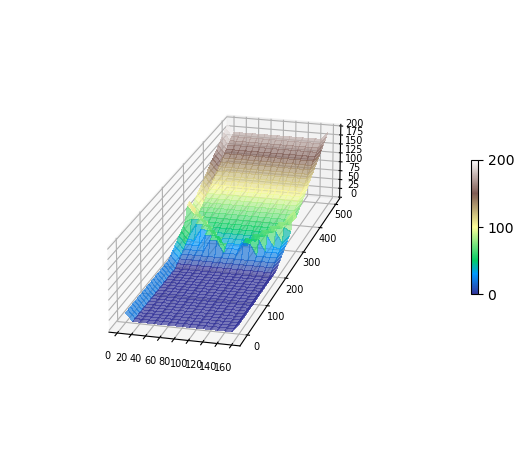

In [16]:
%matplotlib inline
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(projection='3d')
surf_plot_drape(mg,
              surface='topographic__elevation',
              shading = 'topographic__elevation',
              title='',
              clim = [mg.at_node['topographic__elevation'].min(),mg.at_node['topographic__elevation'].max()],
              cmtype = 'sequential',
              colorbar = True)

In [17]:
#%% Add multiflow direction
# run flow director, add slope and receiving node fields
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')

# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'square_root_of_slope')
fd.run_one_step()

### now set up an instance of MassWastingRuntout to landslide and runout on the flume

In [18]:
mw_dict = {'critical slope':[Sc], 'threshold flux':qsc,
            'erosion coefficient':k, 'effective particle diameter':Dp,
            'max observed flow depth':qs_max}
MWRu = MassWastingRunout(mg, mw_dict, 
                         tracked_attributes = ['particle__diameter'],
                         effective_qsi = True, save = True, 
                         grain_shear = True, settle_deposit = False)

 running with spatially variable Dp 


### run the instance of MassWastingRunout

In [19]:
MWRu.run_one_step(run_id = 0)

### view runout extent and how topography changed
#### because change in topography is small relative to dimensions of flume, plot shaded hillshade, colored by topographic change

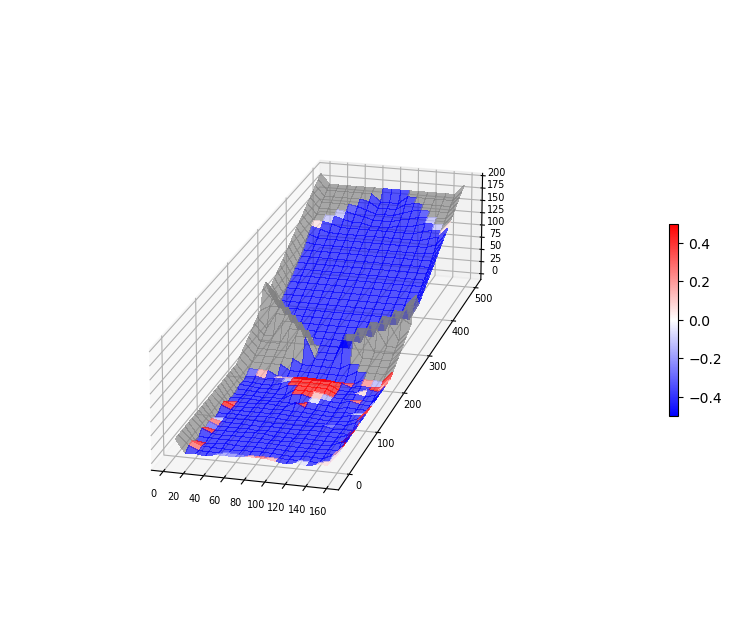

In [20]:
%matplotlib inline
mg.at_node['dem_dif_o'] = mg.at_node['topographic__elevation']-mg.at_node['topographic__initial_elevation']
# exagerate topographic change for visualization
mg.at_node['topographic__elevation_with_change'] = mg.at_node['topographic__initial_elevation']+mg.at_node['dem_dif_o']*5 
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')
surf = surf_plot_drape(mg,
              surface='topographic__elevation_with_change',
              shading = 'dem_dif_o',
              title='',
              clim = [-0.5,0.5],
              colorbar = True)

### view repeat images of runout process

<IPython.core.display.Javascript object>


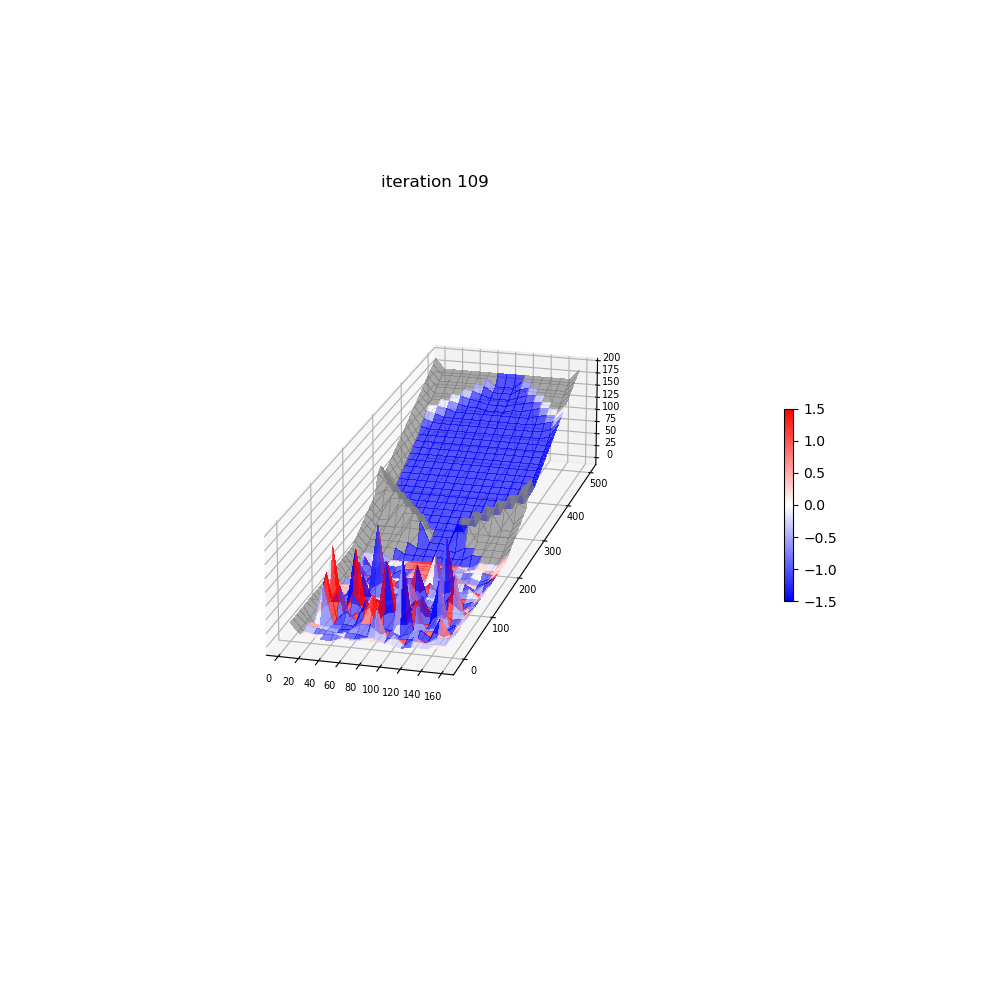

In [21]:
# topo with drape
%matplotlib notebook
def update_plot(frame_number, MWRu, plot):
    mg.at_node['topographic__elevation'] = mg.at_node['topographic__initial_elevation']+(MWRu.runout_evo_maps[0][frame_number]-mg.at_node['topographic__initial_elevation'])*5
    mg.at_node['dem_dif_o'] = MWRu.runout_evo_maps[0][frame_number]-mg.at_node['topographic__initial_elevation']
    plot[0].remove()
    plot[0] = surf_plot_drape(mg ,
                              surface='topographic__elevation',
                              shading='dem_dif_o',
                              title='iteration '+str(frame_number),
                              clim = clim)


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')
nmax=len(MWRu.runout_evo_maps[0].keys())
mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[0][0]
mg.at_node['dem_dif_o'] = MWRu.runout_evo_maps[0][0]-mg.at_node['topographic__initial_elevation']
plot = [surf_plot_drape(mg,surface='topographic__elevation',shading='dem_dif_o',
                        title='iteration '+str(0), clim = clim,colorbar = True)]
animate = animation.FuncAnimation(fig, update_plot, nmax, fargs=(MWRu, plot), repeat = True)
plt.show()